# TP 5 : Statistiques et classification de fleurs

> En *machine learning* (apprentissage automatique), le problème de **classification** consiste à associer à chaque donnée (du texte, une image...) une catégorie. Par exemple : reconnaître un objet sur une image (voiture, chaise...) ou le sentiment d'une phrase (joyeux, triste...).  

Dans ce TP, nous allons reconnaître des variétés d'iris (des fleurs). Veuillez exécuter le code suivant pour charger les données :

In [1]:
from sklearn.datasets import load_iris
import numpy as np
iris = load_iris()

<center><img src=https://raw.githubusercontent.com/cpge-itc/bcpst2/main/files/5_iris/iris.png width=50%></center>

Chaque spécimen d'iris contient les informations suivantes :  
- Variété, qui sera donné par un entier dans la suite : setosa (0), versicolor (1) ou virginica (2) 
- Longueur et largeur de la sépale  
- Longueur et largeur de la pétale

Voici un aperçu global de la répartition des données :

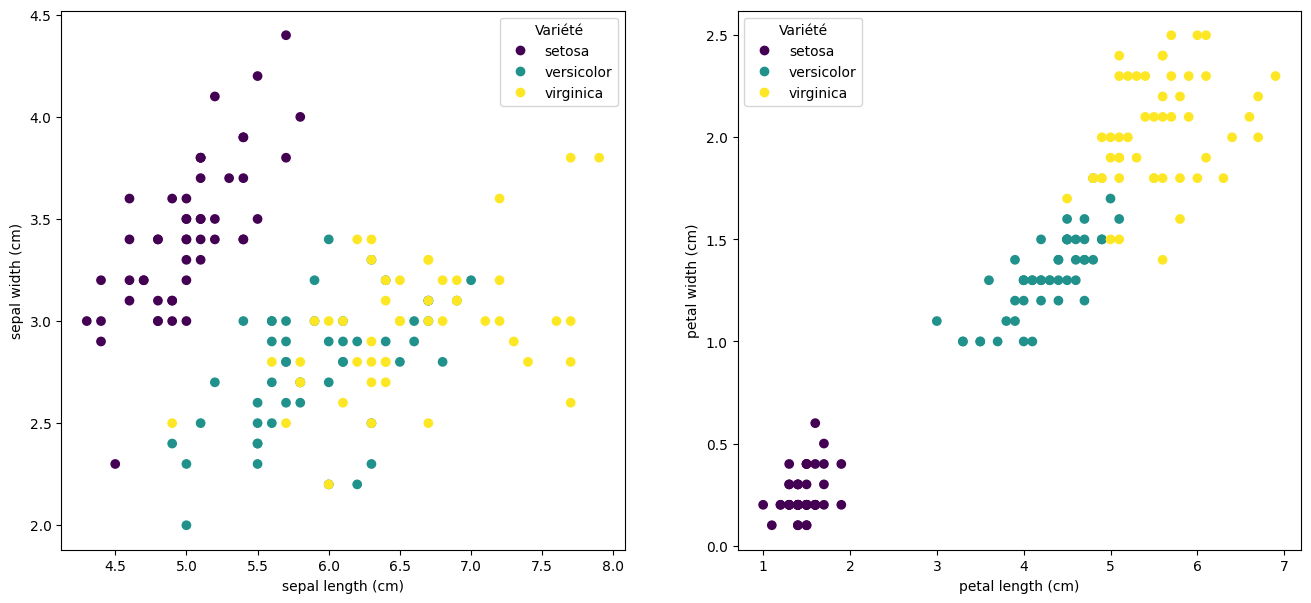

In [2]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(iris.target.min(), iris.target.max())
fig, ax = plt.subplots(1, 2, figsize=(16,7))
for i in range(2):
    ax[i].scatter(iris.data[:, 2*i], iris.data[:, 2*i + 1], c=iris.target, cmap='viridis', norm=norm)
    handles = [plt.Line2D([0, 0], [0, 0], color=cmap(norm(i)), marker='o', linestyle='', label=label) for i, label in enumerate(iris.target_names)]
    ax[i].legend(handles=handles, title='Variété')
    ax[i].set_xlabel(iris.feature_names[2*i])
    ax[i].set_ylabel(iris.feature_names[2*i + 1])
plt.show()

## Statistiques

Nous allons d'abord nous intéresser à quelques propriétés statistiques sur les iris.

Pour obtenir une iris au hasard d'une variété, on utilisera la fonction `random_iris(variety)`, qui renvoie un tableau contenant la longueur de sépale, la largeur de sépale, la longueur de pétale et la largeur de pétale :

In [3]:
import random

def random_iris(variety):
    while True:
        i = random.randrange(len(iris.data))
        if iris.target[i] == variety:
            return iris.data[i]

In [4]:
random_iris(0) # iris aléatoire de variété 0 (setosa)
# le 1er élément du tableau renvoyé est la longueur de sépale
# le 2ème élément est la largeur de sépale
# le 2ème élément est la longueur de pétale
# le 2ème élément est la largeur de pétale

array([4.9, 3.6, 1.4, 0.1])

On rappelle qu'un tableau s'utilise comme une liste (on peut accéder aux éléments avec `[...]`, on peut connaître la taille avec `len`) sauf que :  
- Il n'est pas possible d'ajouter un éléménet à un tableau (pas de `append`)  
- On peut directement sommer deux tableaux, ce qui effectue la somme terme à terme :

In [5]:
T1 = np.array([1, 4]) # tableau contenant les éléments 1 et 4
T2 = np.array([-6, 12]) # tableau contenant les éléments -6 et 12

T1 + T2 # on peut additionner deux tableaux

array([-5, 16])

## Estimateurs

### Échantillon

````{admonition} Exercice
 Écrire une fonction `echantillon(variety, n)` renvoyant une liste composée de `n` tableaux obtenus par des appels à `random_iris(variety)`.
````

In [7]:
echantillon(0, 4)

[array([4.9, 3.1, 1.5, 0.1]),
 array([4.8, 3.1, 1.6, 0.2]),
 array([4.8, 3.1, 1.6, 0.2]),
 array([5.1, 3.8, 1.6, 0.2])]

### Moyenne

Si $x_1$, ..., $x_n$ est un échantillon d'une variable aléatoire $X$, on peut estimer l'espérance de $X$ par :

$$
    \bar{x} = \frac{x_1 + ... + x_n}{n}
$$

````{admonition} Exercice

1. Écrire une fonction `moyenne(L)` renvoyant la moyenne des éléments de d'une liste de nombres `L`.  
2. Du fait qu'on puisse sommer des tableaux numpy, `moyenne(L)` fonctionne aussi si `L` est une liste de tableaux. Vérifier avec `moyenne(echantillon(0, 1000))`, par exemple.
````

In [9]:
moyenne(echantillon(0, 1000))

array([4.9954, 3.4135, 1.4516, 0.2431])

````{admonition} Exercice
 Tester graphiquement avec la fonction suivante, qui affiche les moyennes de chaque variété avec un gros point.
````

In [10]:
def plot_moyenne():
    m = [moyenne(echantillon(i, 1000)) for i in range(3)]
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(iris.target.min(), iris.target.max())
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
    for i in range(2):
        ax[i].scatter(iris.data[:, 2*i], iris.data[:, 2*i + 1], c=iris.target, cmap='viridis', norm=norm)
        handles = [plt.Line2D([0, 0], [0, 0], color=cmap(norm(i)), marker='o', linestyle='', label=label) for i, label in enumerate(iris.target_names)]
        ax[i].legend(handles=handles, title='Variété')
        ax[i].set_xlabel(iris.feature_names[2*i])
        ax[i].set_ylabel(iris.feature_names[2*i + 1])
        for k in range(3):
            ax[i].scatter(m[k][2*i], m[k][2*i + 1], s=300, c=k, cmap='viridis', norm=norm)
    plt.show()

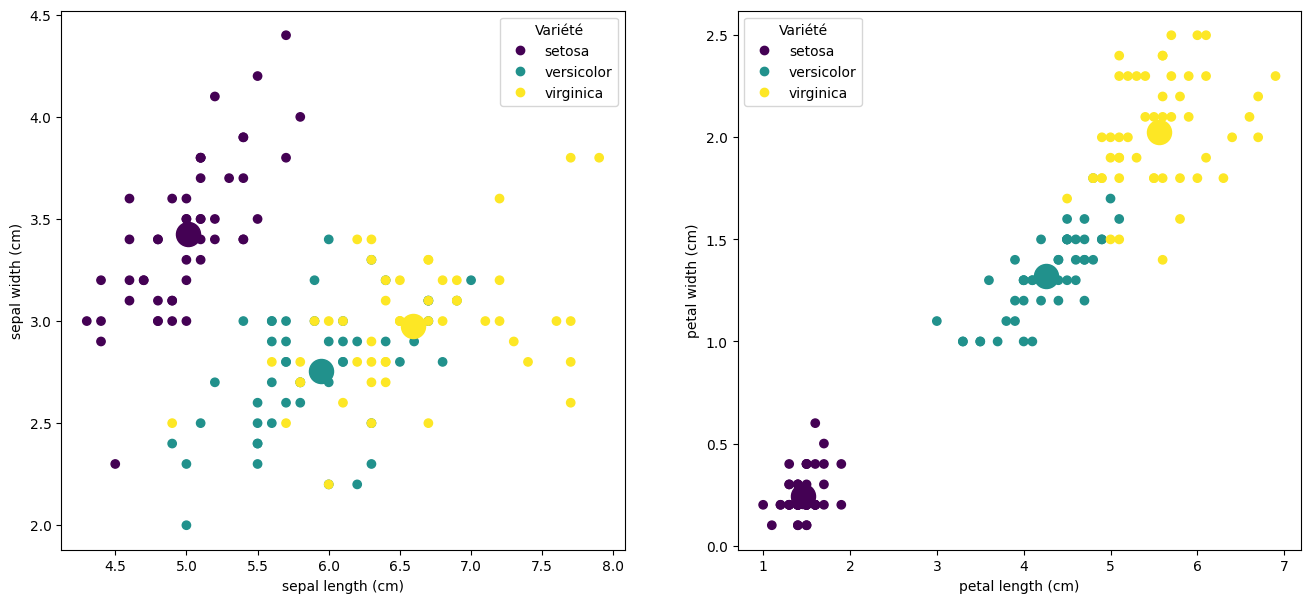

In [11]:
plot_moyenne()

### Écart-type

#### Estimateur biaisé

Pour estimer la variance de $X$à partir d'un échantillon $x_1$, ..., $x_n$, on peut utiliser :

$$
    \sum_{i=1}^n \frac{(x_i - \bar{x})^2}{n}
$$

````{admonition} Exercice
  
1. Écrire une fonction `variance(L)` renvoyant la variance des éléments d'une liste de nombres `L`.  
2. Tester avec un échantillon d'iris, comme pour l'exercice précédent.
````

In [13]:
variance(echantillon(0, 1000))

array([0.11869936, 0.13802176, 0.03323199, 0.01151639])

#### Estimateur sans biais

On peut montrer que $v = \sum_{i=1}^n \frac{(x_i - \bar{x})^2}{n}$ est un estimateur biaisé de la variance, c'est-à-dire que son espérance est différente de la variance. Par contre, $\frac{n - 1}{n}v$ est un estimateur sans biais de la variance.

````{admonition} Exercice
 Écrire une fonction `variance_sans_biais(L)` renvoyant l'estimation sans biais ci-dessus. 
````

In [15]:
variance_sans_biais(echantillon(0, 1000))

array([0.11630358, 0.12793744, 0.03111509, 0.01035738])

## Classification

Un algorithme de classification demande de séparer les données que l'on souhaite en deux ensembles : les **données d'entraînement** que l'on utilise pour améliorer le modèle et les **données de test** pour juger des performances du modèle. 

### Séparation données d'entraînement / test

Le code suivant permet de séparer l'ensemble des iris du jeu de données en deux :

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.5, shuffle=True, random_state=12)

`X_train` contient les caractéristiques de chaque fleur des données d'entraînement. `y_train` contient le numéro de chacune de ces fleurs (0 = setosa, 1 = versicolor, 2 = virginica).

Voici par exemple les caractéristiques (longueur, largeur de sépale et de pétale) de la 1ère fleur des données d'entraînement :

In [17]:
X_train[0]

array([5.6, 2.7, 4.2, 1.3])

Et voici sa variété de fleur :

In [18]:
y_train[0]

1

### Algorithme des $k$ plus proches voisins pour $k = 1$

Nous allons utiliser l'algorithme des $k$ plus proches voisins pour la classification des iris, sous une version simplifiée ($k = 1$).  
Soient $x = (x_0, x_1, x_2, x_3)$ et $y = (y_0, y_1, y_2, y_3)$ deux caractéristiques de fleurs (longueur et largeur de la sépale et de la pétale). On définit la distance $d$ entre ces fleurs par :

$$
    d(x, y) = \sqrt{((x_0 - y_0)^2 + (x_1 - y_1)^2 + (x_2 - y_2)^2 + (x_3 - y_3)^2)}
$$

````{admonition} Exercice
 Écrire une fonction `d` implémentant cette distance (où `x` et `y` sont des listes).
````

In [22]:
d([0.3, 1.2, 4.3, 2.2], [4.1, 2, 3.3, 1.42])

4.085143816317854

Étant donnée une nouvelle donnée $x$ (dans l'ensemble de données test `X_test`), on cherche la donnée de `X_train` la plus proche de $x$.

````{admonition} Exercice
 Écrire une fonction `nearest(x)` renvoyant un indice `j` tel que `X_test[i]` soit à distance minimum de `x`.
````

In [24]:
nearest(X_test[0])

36

````{admonition} Exercice
 En déduire une fonction `predict(x)` renvoyant la variété prédite pour la fleur de caractéristiques `x`.
````

In [26]:
predict(X_test[0])

0

````{admonition} Exercice
 Vérifier graphiquement en utilisant la fonction suivante `plot_nearest(x)` qui affiche les données d'entraînement ainsi qu'une nouvelle donnée `x` (avec un gros point) et sa couleur prédite.
````

In [27]:
def plot_nearest(x):
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(iris.target.min(), iris.target.max())
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
    for j in range(2):
        ax[j].scatter(X_train[:, 2*j], X_train[:, 2*j + 1], c=y_train, cmap='viridis', norm=norm)
        handles = [plt.Line2D([0, 0], [0, 0], color=cmap(norm(i)), marker='o', linestyle='', label=label) for i, label in enumerate(iris.target_names)]
        ax[j].legend(handles=handles, title='Variété')
        ax[j].set_xlabel(iris.feature_names[2*j])
        ax[j].set_ylabel(iris.feature_names[2*j + 1])
        ax[j].scatter(x[2*j], x[2*j + 1], s=300, c=predict(x), cmap='viridis', norm=norm)
    plt.show()

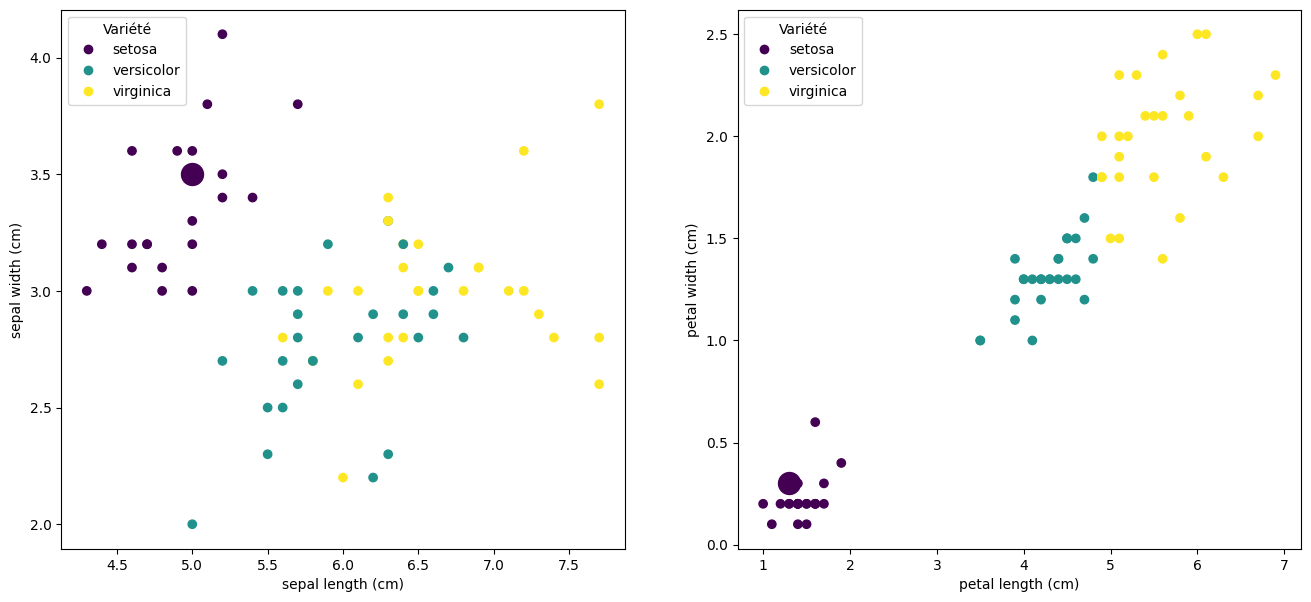

In [28]:
plot_nearest(X_test[0])

### Analyse des résultats

La **précision** d'un modèle est son pourcentage de bonnes réponses. 

````{admonition} Exercice
 Écrire une fonction `precision()` calculant la précision de `predict`. Il faut donc renvoyer le pourcentage de fois que `predict(X_test[i])` est égal à `y_test[i]`
````

In [30]:
precision()

0.9466666666666667

La **matrice de confusion** d'un modèle contient, sur la ligne $i$, colonne $j$, le nombre de prédiction `j` pour une fleur de variété `i`.  
Par exemple, si `predict` a renvoyé 2 pour 10 fleurs de variété 0, il y aura un 10 sur la ligne 0, colonne 2.

````{admonition} Exercice
 Écrire une fonction `confusion()` renvoyant la matrice de confusion obtenue à partir des prédictions sur les données de `X_test`.
````

In [32]:
confusion()

array([[29.,  0.,  0.],
       [ 0., 20.,  1.],
       [ 0.,  3., 22.]])

### $k$ plus proches voisins avec $k$ quelconque

Dans l'algorithme général des $k$ plus proches voisins, on cherche les $k$ données de `X_train` les plus proches de `X_test[i]`, et non pas seulement la plus proche.  
La variété assignée à `X_test[i]` est alors celle qui est majoritaire parmis les $k$ voisins.

````{admonition} Exercice
 Écrire une fonction `occurence(L, e)` renvoyant le nombre de fois que `e` apparait dans `L`.
````

In [34]:
occurence([3, 1, 2, 1, 3, 5, 3], 1)

2

````{admonition} Exercice
 Écrire une fonction `maj(L)` renvoyant l'élément majoritaire parmis une liste de nombres `L`.
````

In [36]:
maj([3, 1, 2, 1, 3, 5, 3])

3

````{admonition} Exercice
 Écrire une fonction `k_nearest(x, k)` renvoyant une listes des indices des `k` éléments les plus proches de `x` dans `X_train`.
````

In [38]:
k_nearest(X_test[0], 4)

[36, 68, 30, 16]

````{admonition} Exercice
 Écrire une fonction `k_predict(x, k)` renvoyant la variété prédise pour `x` en utilisant l'algorithme des `k` plus proches voisins.
````

In [40]:
k_predict(X_test[0], 4)

0

````{admonition} Exercice
 Vérifier graphiquement avec la fonction `plot_knearest(x, k)`. Les `k` plus proches voisins sont notés avec une croix.
````

In [41]:
def plot_knearest(x, k):
    neighbors_i = k_nearest(x, k)
    neighbors = X_train[neighbors_i]
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(iris.target.min(), iris.target.max())
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
    for j in range(2):
        ax[j].scatter(X_train[:, 2*j], X_train[:, 2*j + 1], c=y_train, cmap='viridis', norm=norm)
        handles = [plt.Line2D([0, 0], [0, 0], color=cmap(norm(i)), marker='o', linestyle='', label=label) for i, label in enumerate(iris.target_names)]
        ax[j].legend(handles=handles, title='Variété')
        ax[j].set_xlabel(iris.feature_names[2*j])
        ax[j].set_ylabel(iris.feature_names[2*j + 1])
        ax[j].scatter(x[2*j], x[2*j + 1], s=300, c=k_predict(x, k), cmap='viridis', norm=norm)
        ax[j].scatter(neighbors[:, 2*j], neighbors[:, 2*j + 1], s=120, c=y_train[neighbors_i], cmap='viridis', norm=norm, marker='X')
    plt.show()

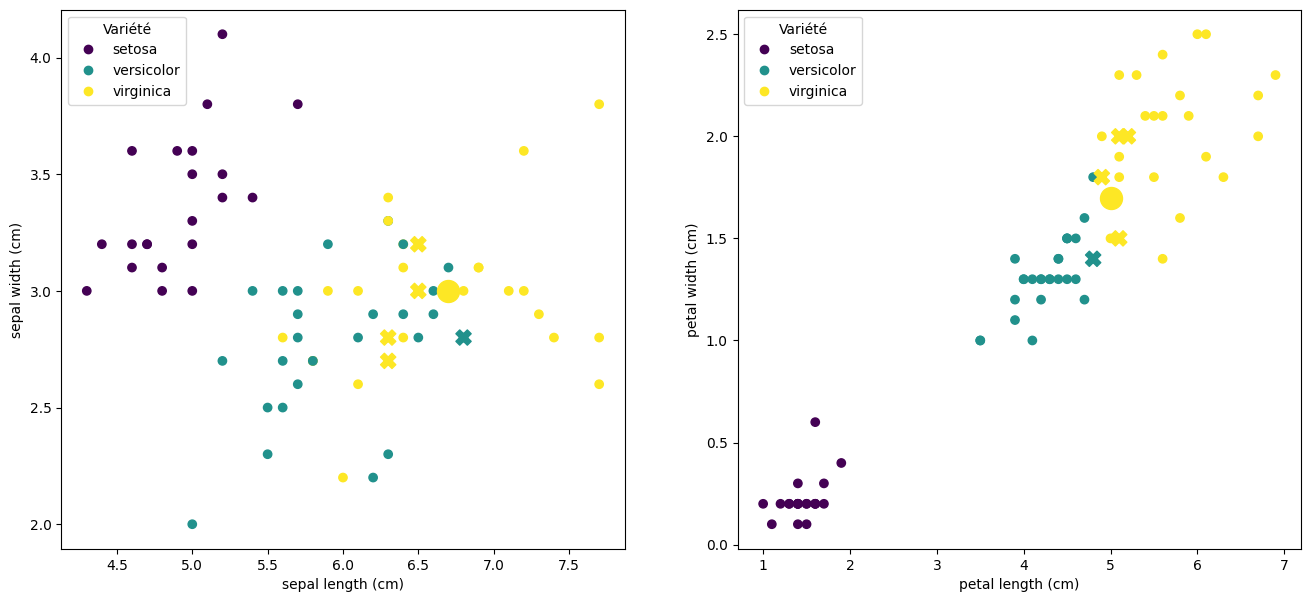

In [42]:
plot_knearest(X_test[26], 5)

````{admonition} Exercice
 Écrire une fonction `kprecision(k)` renvoyant la précision de l'algorithme des $k$ plus proches voisins, pour les données de `X_test`. Qu'observe t-on pour un $k$ trop grand (par exemple 50) ?
````